# OpenGL Compute Shaders: SPA

This notebook is the third in a series of notebooks about general-purpose GPU (GPGPU) computing using OpenGL’s compute shaders with the goal of an accurate and fast GPU implementation of Reda & Andreas's Solar Position Algorithm.  There's still some work to do, but what I have is already useful in many contexts and as I get close to the finish line I wanted to do some more rigorous validation in terms of accuracy and runtime speed, using pvlib's numpy and numba implementations as the baseline.

These comparisons (both error and runtime) will be specific to this particular GPU.  I will be interested to see how the results vary across devices...

In [1]:
import moderngl
import numpy as np
import pandas as pd
import pvlib
import matplotlib.pyplot as plt
import time

This function does the data processing needed to shuffle the arguments to and from the OpenGL kernel, as well as coordinate the kernel execution itself.  Again, no promises that this is the best way to do it -- but it works!

In [2]:
context = moderngl.create_standalone_context(require=430)

def gpu_spa(times, lat, lon, elevation=0, temperature=12, pressure=101325, delta_t=67, atmos_refract=0.5667, groupsize=1024):
    n_times = len(times)
    n_vars = 5
    unixtimes = np.array(times.view(np.int64)/10**9, dtype=np.uint32)
    params = np.array([lat, lon, elevation, temperature, pressure, delta_t, atmos_refract], dtype='f4')

    with open("spa.glsl", "r") as f:
        source = f.read().replace("%%N%%", str(min(n_times, groupsize)))

    compute_shader = context.compute_shader(source)
    
    buffer_times = context.buffer(unixtimes)
    buffer_parameters = context.buffer(params)
    buffer_outputs = context.buffer(reserve=n_vars*4*n_times)

    buffer_times.bind_to_storage_buffer(0)
    buffer_parameters.bind_to_storage_buffer(1)
    buffer_outputs.bind_to_storage_buffer(2)
    
    n_group = 1 + (n_times-1) // groupsize
    compute_shader.run(group_x=n_group)
    
    outputs = np.frombuffer(buffer_outputs.read(), dtype=np.float32)
    out = pd.DataFrame({
        'elevation': outputs[0::n_vars],
        'apparent_elevation': outputs[1::n_vars],
        'zenith': outputs[2::n_vars],
        'apparent_zenith': outputs[3::n_vars],
        'azimuth': outputs[4::n_vars],
    }, index=times)
    return out

# Accuracy Benchmarks

First, check that the GPU implementation gives the same output as pvlib under several test scenarios.  pvlib's numpy implementation is the reference.

## 2019 1-minute simulation

In [3]:
def describe(x1, x2):
    d = x1 - x2
    return pd.DataFrame({
        'rmse': (d**2).mean()**0.5,
        'mbe': d.mean(),
        'mae': d.abs().mean(),
    }).T

In [4]:
times = pd.date_range('2019-01-01', '2020-01-01', freq='T')
gpu = gpu_spa(times, 40, -80)
cpu = pvlib.solarposition.get_solarposition(times, 40, -80)

In [5]:
describe(cpu, gpu)

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
rmse,0.001248,0.001248,0.000568,0.000334,NaN,0.000334
mbe,-0.000004,0.000004,-0.000219,-0.000002,NaN,0.000002
mae,0.000258,0.000258,0.000411,0.000257,NaN,0.000257


In [6]:
filt = cpu['zenith'] < 89
describe(cpu.loc[filt, :], gpu.loc[filt, :])

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
rmse,0.000323,0.000323,0.000561,0.000325,NaN,0.000325
mbe,0.000008,-0.000008,-0.000216,0.000008,NaN,-0.000008
mae,0.000246,0.000246,0.000408,0.000248,NaN,0.000248


Error is very low for this test, although there is likely still some room for improvement.  These results (and all others in this notebook) are still using the `arcsin`/`arctan` hack from the previous post, so there is some accuracy to be gained there if nowhere else.

One of SPA's claims to fame is its accuracy over such a wide time span; I'm not necessarily interested in trying to match that, but we should at least test some years besides 2019:

## 1900–2100 hourly simulation

In [7]:
times = pd.date_range('1900-01-01', '2100-01-01', freq='H')
gpu = gpu_spa(times, 40, -80)
cpu = pvlib.solarposition.get_solarposition(times, 40, -80)

In [8]:
describe(cpu, gpu)

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
rmse,35.638818,35.638818,106.151313,35.629696,NaN,35.629696
mbe,0.411457,-0.411457,4.656588,0.408023,NaN,-0.408023
mae,21.895442,21.895442,64.165011,21.890567,NaN,21.890567


Yikes!  So something is going wrong somewhere... dropping nighttime and the atmospheric correction doesn't fix it either:

In [9]:
filt = cpu['zenith'] < 89
describe(cpu.loc[filt, :], gpu.loc[filt, :])

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
rmse,36.085840,36.085840,85.652276,36.084422,NaN,36.084422
mbe,16.209380,-16.209380,-21.528633,16.198121,NaN,-16.198121
mae,22.415592,22.415592,53.339417,22.417768,NaN,22.417768


Turns out that it all goes haywire for dates prior to Jan 1 2000:

<AxesSubplot:>

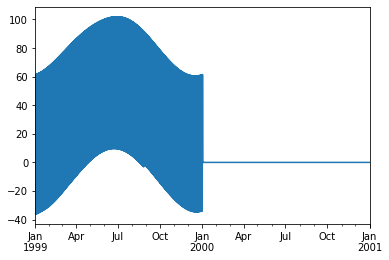

In [10]:
(gpu['zenith'] - cpu['zenith']).loc['1999-01-01':'2001-01-01'].plot()

Guess I need to take another look at my julian date handlers!  Moving on, let's try out different locations to make sure things don't get wonky at negative latitudes or near the poles or something:

## Lat/Lon Sweep

In [11]:
times = pd.date_range('2019-01-01', '2020-01-01', freq='H')

rmse = []
mbe = []
mae = []

for lat in np.arange(-90, 90, 5):
    for lon in np.arange(-180, 180, 10):
        gpu = gpu_spa(times, lat, lon)
        cpu = pvlib.solarposition.get_solarposition(times, lat, lon)
        res = describe(cpu, gpu).assign(lat=lat, lon=lon)
        rmse.append(res.loc['rmse', :])
        mbe.append(res.loc['mbe', :])
        mae.append(res.loc['mae', :])

rmse = pd.concat(rmse, axis=1).T
mbe = pd.concat(mbe, axis=1).T
mae = pd.concat(mae, axis=1).T

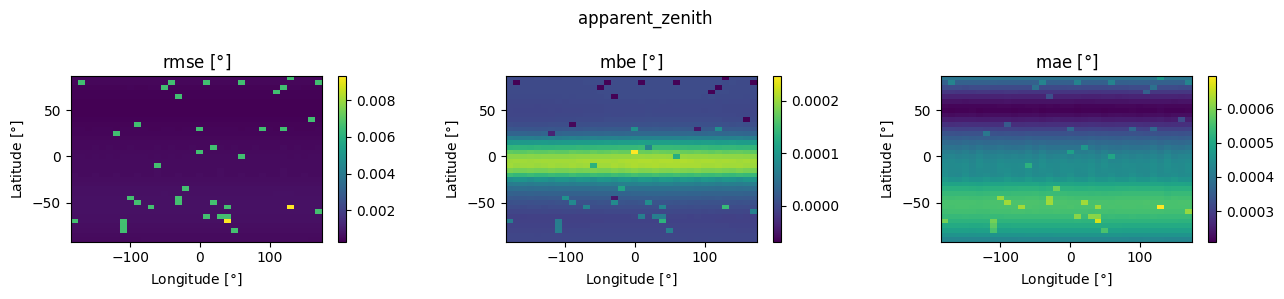

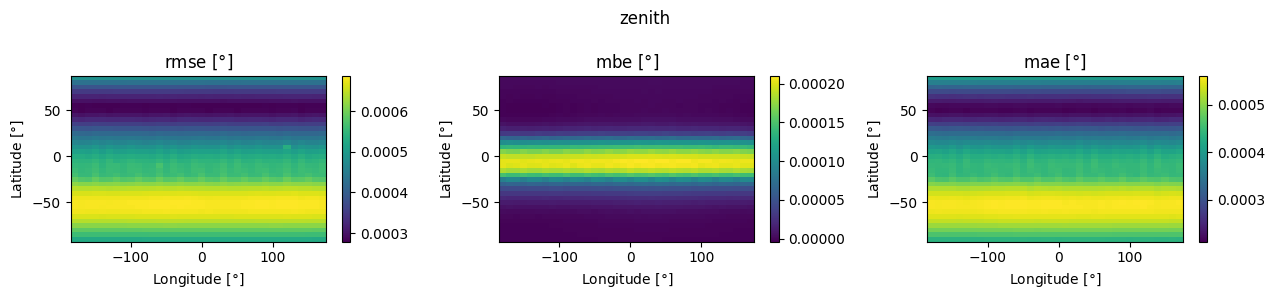

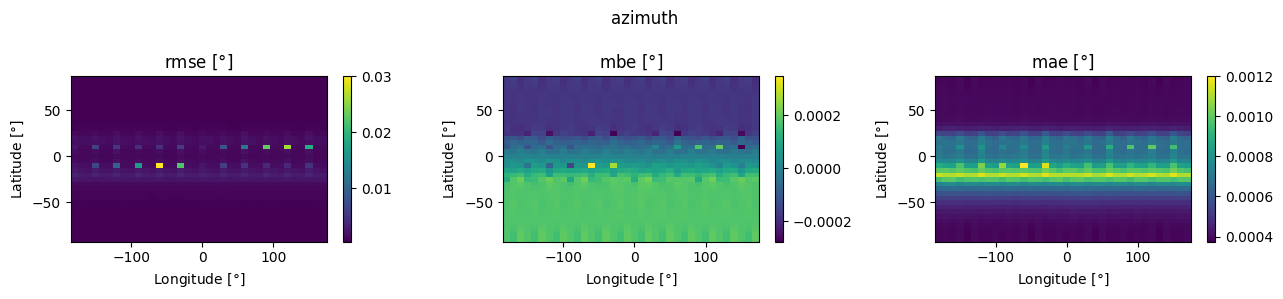

In [12]:
for column in ['apparent_zenith', 'zenith', 'azimuth']:
    fig, axes = plt.subplots(1, 3, figsize=(13, 3), dpi=100)
    for i, (label, err) in enumerate([('rmse', rmse), ('mbe', mbe), ('mae', mae)]):
        piv = err.pivot_table(index='lat',
                              columns='lon',
                              values=column)
        pcm = axes[i].pcolormesh(piv.columns, piv.index, piv, shading='auto')
        axes[i].set_ylabel(r'Latitude [$\degree$]')
        axes[i].set_xlabel(r'Longitude [$\degree$]')
        axes[i].set_title(fr'{label} [$\degree$]')
        plt.colorbar(pcm, ax=axes[i])

    fig.suptitle(column)
    fig.tight_layout()

Some interesting patterns that I'm not immediately sure how to interpret, but in any case the variation with location doesn't seem very significant.  Now let's play with the other SPA knobs:

## Refraction Correction

The SPA zenith refraction correction depends on annual average temperature and pressure.  To make sure that correction is calculated correctly, let's sweep across both and ensure that refraction-corrected ("apparent") zenith still matches between the two implementations.  The temperatures and pressures chosen here are each roughly representative of the ranges found on Earth, although certain combinations might not be particularly realistic.

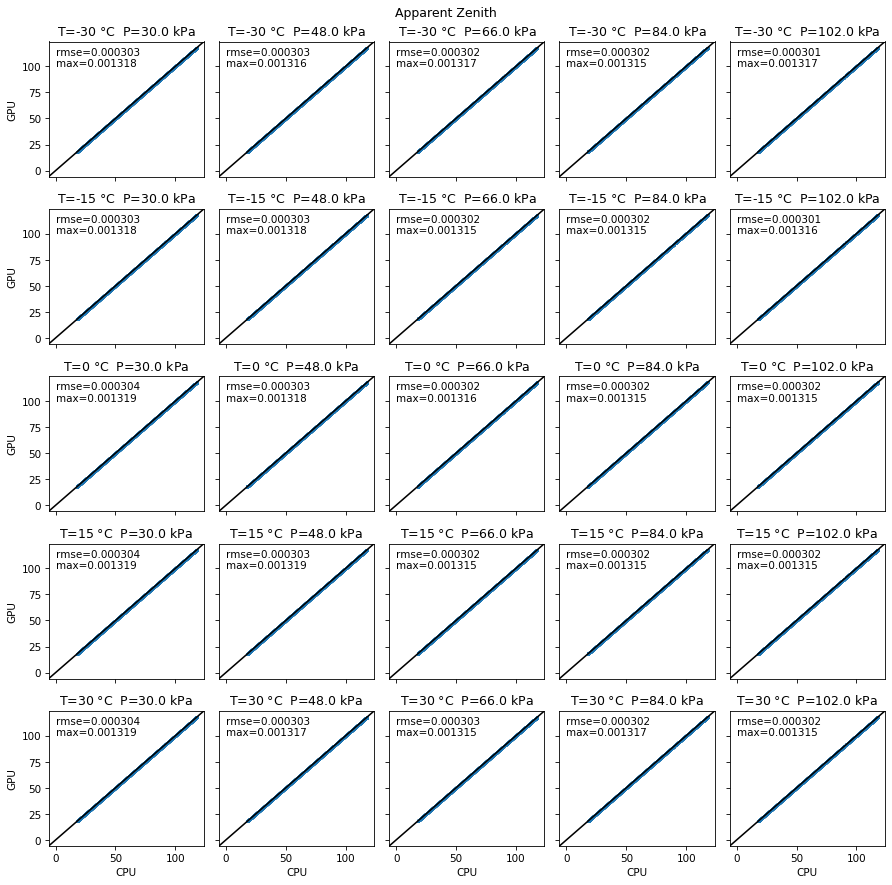

In [13]:
times = pd.date_range('2019-06-01', '2019-06-02', freq='10s')

n = 5
fig, axes = plt.subplots(n, n, sharex=True, sharey=True, dpi=75, figsize=(12, 12))

for i, temperature in enumerate(np.linspace(-30, 30, num=n)):
    for j, pressure in enumerate(np.linspace(30000, 102000, num=n)):
        gpu = gpu_spa(times, 40, -80, pressure=pressure, temperature=temperature)
        cpu = pvlib.solarposition.get_solarposition(times, 40, -80, pressure=pressure, temperature=temperature)
        rmse = np.mean((gpu['apparent_zenith'] - cpu['apparent_zenith'])**2)**0.5
        emax = np.max(np.abs(gpu['apparent_zenith'] - cpu['apparent_zenith']))
        axes[i, j].scatter(cpu['apparent_zenith'], gpu['apparent_zenith'], s=1)
        axes[i, j].axline((0, 0), slope=1, c='k')
        axes[i, j].set_title(f'T={temperature:0.0f} $\degree$C  P={pressure/1000:0.01f} kPa')
        axes[i, j].text(0, 100, f'rmse={rmse:0.06f}\nmax={emax:0.06f}')

for i in range(n):
    axes[i, 0].set_ylabel('GPU')
    axes[n-1, i].set_xlabel('CPU')

fig.suptitle('Apparent Zenith')
fig.tight_layout()

All looks pretty good here.  Now, on to comparing calculation times!

# Execution Speed Benchmarks

My first-order mental model of GPU processing is that runtime is a combination of fixed costs (shader compilation, OpenGL context overhead) that are more or less constant for any input and variable costs (memory allocation, data transfer, and of course the actual algorithm runtime) that scale with the number of timestamps being simulated.  So of course it will be interesting to compare runtimes across a range of $N$, the number of simulated timestamps.

In [14]:
import warnings
warnings.filterwarnings('ignore', message='reloading spa')

timings = []

for n in 10**np.arange(1, 8):
    times = pd.date_range('2019-01-01', freq='T', periods=n)
    timing = {'N': n}

    st = time.perf_counter()
    _ = pvlib.solarposition.spa_python(times, 40, -80, how='numpy')
    ed = time.perf_counter()
    timing['cpu (numpy)'] = ed - st

    # warmup
    _ = pvlib.solarposition.spa_python(times[:10], 40, -80, how='numba')

    st = time.perf_counter()
    _ = pvlib.solarposition.spa_python(times, 40, -80, how='numba', numthreads=4)
    ed = time.perf_counter()
    timing['cpu (numba, 4 threads)'] = ed - st

    st = time.perf_counter()
    _ = pvlib.solarposition.spa_python(times, 40, -80, how='numba', numthreads=8)
    ed = time.perf_counter()
    timing['cpu (numba, 8 threads)'] = ed - st

    st = time.perf_counter()
    _ = pvlib.solarposition.spa_python(times, 40, -80, how='numba', numthreads=16)
    ed = time.perf_counter()
    timing['cpu (numba, 16 threads)'] = ed - st

    st = time.perf_counter()
    _ = gpu_spa(times, 40, -80)
    ed = time.perf_counter()
    timing['gpu'] = ed - st

    timings.append(timing)

timings = pd.DataFrame(timings).set_index('N')

/home/kevin/miniconda3/envs/dev/lib/python3.8/site-packages/pvlib/spa.py:991: UserWarning: The number of threads is more than the length of the time array. Only using %s threads.
  warnings.warn('The number of threads is more than the length of '


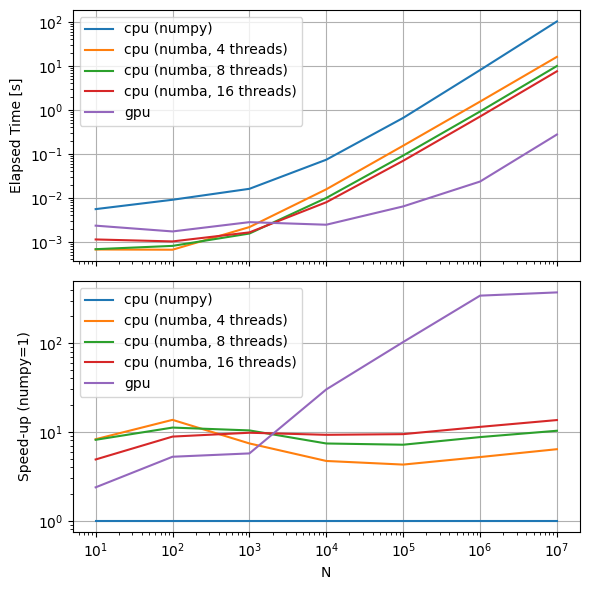

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, dpi=100, figsize=(6, 6))
timings.plot(ax=axes[0], logx=True, logy=True)
axes[0].set_ylabel('Elapsed Time [s]')
axes[0].grid()

ratio = 1/timings.divide(timings['cpu (numpy)'], axis=0)
ratio.plot(ax=axes[1], logx=True, logy=True)
axes[1].set_ylabel('Speed-up (numpy=1)')
axes[1].grid()

fig.tight_layout()

So, on this machine, the GPU implementation is:

- Faster than the numpy implementation for all N
- Faster than the numba implementation starting somewhere between 1000 and 10000 timestamps
- Vastly faster (two orders of magnitude) for 100000 timestamps and beyond

So for an 8760 you might expect a (20x, 3x) speedup over (numpy, numba).  For an annual 1-minute simulation (N=525600), the speedup might be (200x, 20x) over (numpy, numba).  Boggles the mind, especially considering that this GPU is a weeny integrated GPU (I think)!

Here are the same timings in tabular form, for reference:

In [16]:
timings

,cpu (numpy),"cpu (numba, 4 threads)","cpu (numba, 8 threads)","cpu (numba, 16 threads)",gpu
N,,,,,
10,0.005542,0.000670,0.000681,0.001133,0.002333
100,0.009041,0.000662,0.000809,0.001022,0.001723
1000,0.016032,0.002164,0.001544,0.001640,0.002802
10000,0.073568,0.015643,0.009942,0.007940,0.002448
100000,0.655516,0.153031,0.091456,0.069525,0.006387
1000000,8.010285,1.538795,0.917086,0.703851,0.023457
10000000,102.137903,16.005205,9.922412,7.520801,0.275046


In [17]:
ratio

,cpu (numpy),"cpu (numba, 4 threads)","cpu (numba, 8 threads)","cpu (numba, 16 threads)",gpu
N,,,,,
10,1.0,8.266644,8.141435,4.890245,2.375776
100,1.0,13.652682,11.175203,8.847653,5.247172
1000,1.0,7.407335,10.382628,9.775966,5.720831
10000,1.0,4.702821,7.399333,9.265220,30.048933
100000,1.0,4.283561,7.167524,9.428449,102.639141
1000000,1.0,5.205558,8.734495,11.380647,341.483374
10000000,1.0,6.381543,10.293657,13.580722,371.348489


Closing thoughts:

- It's a shame that the shader compilation cost is incurred on every invocation.  I want to see if I can modify the shader in such a way that I can compile it once but apply it to an input of any length.  That would hopefully make it more competitive with numba for the smaller inputs.
- Definitely need to fix that "reverse Y2K bug"...
- Definitely want to re-run this notebook on a different computer.  I've addressed the big error sources on this machine, but the fact that the trignometric functions have such large error here gives me significant pause -- maybe other computers will have totally different error sources.  If the error is acceptable across machines (or I rewrite the code to only use "safe" GLSL functions), then evaluating the speed-up with a proper beefy GPU would be very cool.